<a href="https://colab.research.google.com/github/samarlasureshkumar/samarlasureshkumar/blob/main/ACSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━

IndexError: list index out of range

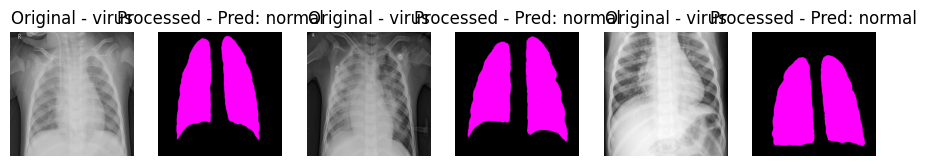

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import gc

# Define paths to dataset directories
base_dir = '/content/drive/MyDrive/Lung_data'
processed_dir = '/content/drive/MyDrive/Processed1_Images'
folders = ['img', 'mask', 'ann']
classes = ['virus', 'bacteria', 'pneumonia', 'normal']

# Ensure the processed directory exists
os.makedirs(processed_dir, exist_ok=True)

# Function to apply color mapping based on image class
def apply_class_specific_color_map(image, class_label):
    if class_label == 'normal':
        # Apply a different color map to highlight normal lung structures
        enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
    elif class_label == 'pneumonia':
        # Apply a color map that emphasizes areas of consolidation and opacity
        enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    else:
        # Return the image as-is for 'virus' and 'bacteria'
        enhanced_image = image
    return enhanced_image

# Function for contrast enhancement using CLAHE
def enhance_contrast_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 2:  # Grayscale image
        enhanced_image = clahe.apply(image)
    else:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        enhanced_image = cv2.merge((l, a, b))
        enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_LAB2BGR)
    return enhanced_image

# Function to highlight textures using Gabor filters
def enhance_texture_gabor(image):
    gabor_kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kernel = cv2.getGaborKernel((21, 21), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_kernels.append(kernel)

    filtered_images = [cv2.filter2D(image, cv2.CV_8UC3, kernel) for kernel in gabor_kernels]
    texture_enhanced_image = np.maximum.reduce(filtered_images)
    return texture_enhanced_image

# Function to process and save images using updated preprocessing
def process_and_save_images_updated(images, masks, labels, save_dir, max_workers=4):
    def save_image(processed_image, label, img_name):
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, img_name)
        cv2.imwrite(save_path, processed_image)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for image, mask, label in zip(images, masks, labels):
            if label in ['normal', 'pneumonia']:
                # Enhance contrast and texture based on the class
                contrast_enhanced_image = enhance_contrast_clahe(image)
                texture_enhanced_image = enhance_texture_gabor(contrast_enhanced_image)
                color_mapped_image = apply_class_specific_color_map(texture_enhanced_image, label)
                # Save processed image
                img_name = f"{label}_{hash(image.tobytes())}.png"
                executor.submit(save_image, color_mapped_image, label, img_name)

# Function to load images, masks, and annotations
def load_data(base_dir, folders, classes):
    images = []
    masks = []
    labels = []
    for label in classes:
        img_dir = os.path.join(base_dir, 'img', label)
        mask_dir = os.path.join(base_dir, 'mask', label)
        for img_name in os.listdir(img_dir):
            if img_name.endswith('.png'):  # Ensure correct file type
                img_path = os.path.join(img_dir, img_name)
                mask_path = os.path.join(mask_dir, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                masks.append(mask)
                labels.append(label)
    return images, masks, labels

# Function to load processed images and their labels
def load_processed_images(processed_dir, classes):
    images = []
    labels = []
    for label in classes:
        label_dir = os.path.join(processed_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image = cv2.imread(img_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Function to extract CNN features in parallel
def extract_features_cnn_parallel(images, max_workers=2):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    def process_image_for_cnn(image):
        resized_image = cv2.resize(image, (224, 224))
        if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        array_image = img_to_array(resized_image)
        expanded_image = np.expand_dims(array_image, axis=0)
        preprocessed_image = expanded_image / 255.0
        feature = model.predict(preprocessed_image)
        return feature.flatten()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(process_image_for_cnn, images))
    return np.array(features)

# Load the dataset
images, masks, labels = load_data(base_dir, folders, classes)

# Phase 1: Process images and save them (only for 'normal' and 'pneumonia')
process_and_save_images_updated(images, masks, labels, processed_dir, max_workers=4)
gc.collect()  # Free up memory after processing

# Phase 2: Load processed images (reuse for 'virus' and 'bacteria', update for 'normal' and 'pneumonia')
processed_images, processed_labels = load_processed_images(processed_dir, classes)

# Convert labels to numeric
labels_numeric = pd.Categorical(processed_labels).codes

# Phase 3: Extract CNN features from processed images
features_cnn = extract_features_cnn_parallel(processed_images, max_workers=2)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_cnn, labels_numeric, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Function to display original, processed images and predictions
def display_sample_predictions(processed_images, processed_labels, clf, num_samples=3):
    plt.figure(figsize=(15, num_samples * 5))
    for idx, label in enumerate(classes):
        class_indices = [i for i, l in enumerate(processed_labels) if l == label]
        sample_indices = np.random.choice(class_indices, num_samples, replace=False)
        for i, sample_idx in enumerate(sample_indices):
            original_image = cv2.imread(os.path.join(base_dir, 'img', label, os.listdir(os.path.join(base_dir, 'img', label))[sample_idx]), cv2.IMREAD_GRAYSCALE)
            processed_image = processed_images[sample_idx]
            feature_cnn = extract_features_cnn_parallel([processed_image], max_workers=1)
            prediction = clf.predict(feature_cnn)[0]
            predicted_label = classes[prediction]
            plt.subplot(num_samples, 2 * len(classes), idx * 2 * num_samples + 2 * i + 1)
            plt.imshow(original_image, cmap='gray')
            plt.title(f"Original - {label}")
            plt.axis('off')
            plt.subplot(num_samples, 2 * len(classes), idx * 2 * num_samples + 2 * i + 2)
            plt.imshow(processed_image)
            plt.title(f"Processed - Pred: {predicted_label}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample predictions
display_sample_predictions(processed_images, processed_labels, clf, num_samples=3)


In [ ]:
# Function to load processed images and their labels
def load_processed_images(processed_dir, classes):
    images = []
    labels = []
    for label in classes:
        label_dir = os.path.join(processed_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image = cv2.imread(img_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Function to extract CNN features in parallel
def extract_features_cnn_parallel(images, max_workers=2):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    def process_image_for_cnn(image):
        resized_image = cv2.resize(image, (224, 224))
        if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        array_image = img_to_array(resized_image)
        expanded_image = np.expand_dims(array_image, axis=0)
        preprocessed_image = expanded_image / 255.0
        feature = model.predict(preprocessed_image)
        return feature.flatten()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(process_image_for_cnn, images))
    return np.array(features)

XGBoost

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import gc

# Define paths to dataset directories
base_dir = '/content/drive/MyDrive/Lung_data'
processed_dir = '/content/drive/MyDrive/Processed1_Images'
folders = ['img', 'mask', 'ann']
classes = ['virus', 'bacteria', 'pneumonia', 'normal']

# Ensure the processed directory exists
os.makedirs(processed_dir, exist_ok=True)

# Data augmentation generator for pneumonia class
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply color mapping based on image class
def apply_class_specific_color_map(image, class_label):
    if class_label == 'normal':
        # Apply a different color map to highlight normal lung structures
        enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
    elif class_label == 'pneumonia':
        # Apply a color map that emphasizes areas of consolidation and opacity
        enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    else:
        # Return the image as-is for 'virus' and 'bacteria'
        enhanced_image = image
    return enhanced_image

# Function for contrast enhancement using CLAHE
def enhance_contrast_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 2:  # Grayscale image
        enhanced_image = clahe.apply(image)
    else:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        enhanced_image = cv2.merge((l, a, b))
        enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_LAB2BGR)
    return enhanced_image

# Function to highlight textures using Gabor filters
def enhance_texture_gabor(image):
    gabor_kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kernel = cv2.getGaborKernel((21, 21), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_kernels.append(kernel)

    filtered_images = [cv2.filter2D(image, cv2.CV_8UC3, kernel) for kernel in gabor_kernels]
    texture_enhanced_image = np.maximum.reduce(filtered_images)
    return texture_enhanced_image

def process_and_save_images_updated(images, masks, labels, save_dir, max_workers=4):
    def save_image(processed_image, label, img_name):
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, img_name)
        cv2.imwrite(save_path, processed_image)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for image, mask, label in zip(images, masks, labels):
            if label in ['normal', 'pneumonia']:
                # Enhance contrast and texture based on the class
                contrast_enhanced_image = enhance_contrast_clahe(image)
                texture_enhanced_image = enhance_texture_gabor(contrast_enhanced_image)
                color_mapped_image = apply_class_specific_color_map(texture_enhanced_image, label)

                # If the label is pneumonia, augment the data
                if label == 'pneumonia':
                    # Convert the grayscale image to a 4D array (batch_size, height, width, channels)
                    image_expanded = np.expand_dims(image, axis=-1)  # Adding channel dimension
                    image_expanded = np.expand_dims(image_expanded, axis=0)  # Adding batch dimension
                    augmented_images = augmentor.flow(image_expanded, batch_size=1)

                    for i in range(5):  # Generate 5 augmented images per pneumonia image
                        aug_image = next(augmented_images)[0].astype(np.uint8)
                        aug_image = np.squeeze(aug_image)  # Remove the batch dimension
                        aug_image_name = f"{label}_aug_{i}_{hash(aug_image.tobytes())}.png"
                        executor.submit(save_image, aug_image, label, aug_image_name)

                # Save processed image
                img_name = f"{label}_{hash(image.tobytes())}.png"
                executor.submit(save_image, color_mapped_image, label, img_name)
            else:
                # Skip preprocessing for 'virus' and 'bacteria'
                continue


# Function to load images, masks, and annotations
def load_data(base_dir, folders, classes):
    images = []
    masks = []
    labels = []
    for label in classes:
        img_dir = os.path.join(base_dir, 'img', label)
        mask_dir = os.path.join(base_dir, 'mask', label)
        for img_name in os.listdir(img_dir):
            if img_name.endswith('.png'):  # Ensure correct file type
                img_path = os.path.join(img_dir, img_name)
                mask_path = os.path.join(mask_dir, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                masks.append(mask)
                labels.append(label)
    return images, masks, labels

# Function to load processed images and their labels
def load_processed_images(processed_dir, classes):
    images = []
    labels = []
    for label in classes:
        label_dir = os.path.join(processed_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image = cv2.imread(img_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Function to extract CNN features in parallel
def extract_features_cnn_parallel(images, max_workers=2):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    def process_image_for_cnn(image):
        resized_image = cv2.resize(image, (224, 224))
        if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        array_image = img_to_array(resized_image)
        expanded_image = np.expand_dims(array_image, axis=0)
        preprocessed_image = expanded_image / 255.0
        feature = model.predict(preprocessed_image)
        return feature.flatten()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(process_image_for_cnn, images))
    return np.array(features)

# Load the dataset
images, masks, labels = load_data(base_dir, folders, classes)

# Phase 1: Process images and save them (only for 'normal' and 'pneumonia')
process_and_save_images_updated(images, masks, labels, processed_dir, max_workers=4)
gc.collect()  # Free up memory after processing

# Phase 2: Load processed images (reuse for 'virus' and 'bacteria', update for 'normal' and 'pneumonia')
processed_images, processed_labels = load_processed_images(processed_dir, classes)

# Convert labels to numeric
labels_numeric = pd.Categorical(processed_labels).codes

# Phase 3: Extract CNN features from processed images
features_cnn = extract_features_cnn_parallel(processed_images, max_workers=2)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_cnn, labels_numeric, test_size=0.2, random_state=42)

# Train individual models for ensemble
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define ensemble model using voting classifier
ensemble_clf = VotingClassifier(estimators=[('rf', rf_clf), ('xgb', xgb_clf)], voting='soft')
ensemble_clf.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred = ensemble_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

       virus       0.71      0.89      0.79       521
    bacteria       1.00      1.00      1.00       532
   pneumonia       0.98      0.92      0.95       148
      normal       0.64      0.36      0.46       286

    accuracy                           0.83      1487
   macro avg       0.83      0.79      0.80      1487
weighted avg       0.83      0.83      0.82      1487

Confusion Matrix:
 [[464   0   2  55]
 [  0 532   0   0]
 [  7   2 136   3]
 [181   0   1 104]]
Accuracy Score: 0.8312037659717552


In [ ]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


Augmentation

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import gc

# Define paths to dataset directories
base_dir = '/content/drive/MyDrive/Lung_data'
processed_dir = '/content/drive/MyDrive/Lung_data/Processed_images'
folders = ['img', 'mask', 'ann']
classes = ['virus', 'bacteria', 'pneumonia', 'normal']

# Ensure the processed directory exists
os.makedirs(processed_dir, exist_ok=True)

# Data augmentation generator for the 'normal' class
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function for contrast enhancement using CLAHE
def enhance_contrast_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 2:  # Grayscale image
        enhanced_image = clahe.apply(image)
    else:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        enhanced_image = cv2.merge((l, a, b))
        enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_LAB2BGR)
    return enhanced_image

# Function to apply color mapping based on image class
def apply_class_specific_color_map(image, class_label):
    if class_label == 'normal':
        # Apply a different color map to highlight normal lung structures
        enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
    elif class_label == 'pneumonia':
        # Apply a color map that emphasizes areas of consolidation and opacity
        enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    else:
        # Return the image as-is for 'virus' and 'bacteria'
        enhanced_image = image
    return enhanced_image

# Function to load images, masks, and annotations
def load_data(base_dir, folders, classes):
    images = []
    masks = []
    labels = []
    for label in classes:
        img_dir = os.path.join(base_dir, 'img', label)
        mask_dir = os.path.join(base_dir, 'mask', label)
        for img_name in os.listdir(img_dir):
            if img_name.endswith('.png'):  # Ensure correct file type
                img_path = os.path.join(img_dir, img_name)
                mask_path = os.path.join(mask_dir, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                masks.append(mask)
                labels.append(label)
    return images, masks, labels

# Function to augment and save preprocessed images
def preprocess_augment_and_save_images(images, labels, save_dir, class_to_augment='normal', max_workers=4, batch_size=10):
    def save_image(processed_image, label, img_name):
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, img_name)
        cv2.imwrite(save_path, processed_image)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            for image, label in zip(batch_images, batch_labels):
                if label == class_to_augment:
                    # Preprocess the image
                    contrast_enhanced_image = enhance_contrast_clahe(image)
                    preprocessed_image = apply_class_specific_color_map(contrast_enhanced_image, label)

                    # Convert the preprocessed grayscale image to a 4D array (batch_size, height, width, channels)
                    image_expanded = np.expand_dims(preprocessed_image, axis=0)  # Adding batch dimension

                    # Apply augmentation
                    augmented_images = augmentor.flow(image_expanded, batch_size=1)

                    for j in range(5):  # Generate 5 augmented images per preprocessed image
                        aug_image = next(augmented_images)[0].astype(np.uint8)
                        aug_image = np.squeeze(aug_image)  # Remove the batch dimension
                        aug_image_name = f"{label}_aug_{j}_{hash(aug_image.tobytes())}.png"
                        executor.submit(save_image, aug_image, label, aug_image_name)
                else:
                    continue
            del batch_images, batch_labels  # Clear memory for the batch
            gc.collect()  # Free up memory after processing each batch

# Load the dataset
images, masks, labels = load_data(base_dir, folders, classes)

# Phase 1: Preprocess and augment 'normal' class images, then save them in batches
preprocess_augment_and_save_images(images, labels, processed_dir, class_to_augment='normal', max_workers=4, batch_size=10)

# Function to load processed images and their labels
def load_processed_images(processed_dir, classes):
    images = []
    labels = []
    for label in classes:
        label_dir = os.path.join(processed_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image = cv2.imread(img_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Phase 2: Load processed images (reuse for 'virus' and 'bacteria', update for 'normal' and 'pneumonia')
processed_images, processed_labels = load_processed_images(processed_dir, classes)

# Convert labels to numeric
labels_numeric = pd.Categorical(processed_labels).codes

# Function to extract CNN features in parallel
def extract_features_cnn_parallel(images, max_workers=2):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    def process_image_for_cnn(image):
        resized_image = cv2.resize(image, (224, 224))
        if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        array_image = img_to_array(resized_image)
        expanded_image = np.expand_dims(array_image, axis=0)
        preprocessed_image = expanded_image / 255.0
        feature = model.predict(preprocessed_image)
        return feature.flatten()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(process_image_for_cnn, images))
    return np.array(features)

# Phase 3: Extract CNN features from processed images
features_cnn = extract_features_cnn_parallel(processed_images, max_workers=4)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_cnn, labels_numeric, test_size=0.2, random_state=42)

# Define the parameter distribution for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist,
                                   n_iter=10, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters found: ", random_search.best_params_)

# Use the best estimator from random search
best_xgb_clf = random_search.best_estimator_

# Evaluate the best model
y_pred = best_xgb_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 82ms/step
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters found:  {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Classification Report:
               precision    recall  f1-score   support

       virus       0.67      0.87      0.76       503
    bacteria       0.97      0.96      0.96      1102
   pneumonia       1.00      0.32      0.49        28
      normal       0.62      0.36      0.45       285

    accuracy                           0.84      1918
   macro avg       0.81      0.63      0.67      1918
weighted avg       0.84      0.84      0.83      1918

Confusion Matrix:
 [[ 440   16    0   47]
 [  33 1054    0   15]
 [  18    0    9    1]
 [ 166   17    0  102]]
Accuracy Score: 0.8368091762252347


Hyper parameter tuining

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter distribution for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist,
                                   n_iter=10, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters found: ", random_search.best_params_)

# Use the best estimator from random search
best_xgb_clf = random_search.best_estimator_

# Evaluate the best model
y_pred = best_xgb_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:11:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters found:  {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Classification Report:
               precision    recall  f1-score   support

       virus       0.67      0.86      0.75       503
    bacteria       0.97      0.96      0.96      1102
   pneumonia       1.00      0.29      0.44        28
      normal       0.60      0.36      0.45       285

    accuracy                           0.83      1918
   macro avg       0.81      0.62      0.65      1918
weighted avg       0.83      0.83      0.82      1918

Confusion Matrix:
 [[ 434   16    0   53]
 [  32 1056    0   14]
 [  17    2    8    1]
 [ 164   19    0  102]]
Accuracy Score: 0.8342022940563086


Preprocessing

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from concurrent.futures import ThreadPoolExecutor
import gc

# Define paths to dataset directories
base_dir = '/content/drive/MyDrive/Lung_data'
processed_dir = '/content/drive/MyDrive/pre-Processed_images'
folders = ['img', 'mask', 'ann']
classes = ['bacteria', 'virus']

# Ensure the processed directory exists
os.makedirs(processed_dir, exist_ok=True)

# Function to segment tissues within the lungs
def segment_tissues_within_lungs(image, lung_mask):
    segmented_tissues = cv2.bitwise_and(image, image, mask=lung_mask)
    return segmented_tissues

# Function to detect blood vessels using edge detection
def detect_blood_vessels(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    vessels = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    return vessels

# Function for bronchial tree segmentation
def segment_bronchial_tree(image):
    ret, thresh = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    bronchi = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    return bronchi

# Function to perform pleural analysis
def pleural_analysis(image):
    edges = cv2.Canny(image, 100, 200)
    pleural_features = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=1)
    return pleural_features

# Function to detect nodules and masses
def detect_nodules_masses(image):
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(image)

    nodules_masses = np.zeros_like(image)

    for keypoint in keypoints:
        x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
        cv2.circle(nodules_masses, (x, y), int(keypoint.size / 2), (255), -1)

    return nodules_masses

# Function for lung lobe segmentation
def segment_lung_lobes(image):
    lobes = cv2.applyColorMap(image, cv2.COLORMAP_JET)  # This is a placeholder for actual lobe segmentation
    return lobes

# Function for emphysema detection
def detect_emphysema(image):
    emphysema_mask = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return emphysema_mask

# Function for tissue-specific color mapping restricted to lung area
def color_map_tissues(segmented_tissues, blood_vessels, bronchial_tree, nodules_masses, texture_map, lung_mask):
    # Initialize a blank RGB image for the color-mapped output
    color_mapped = np.zeros((segmented_tissues.shape[0], segmented_tissues.shape[1], 3), dtype=np.uint8)

    # Apply different colors for different tissues restricted to lung area using lung_mask
    color_mapped[(segmented_tissues != 0) & (lung_mask != 0)] = [0, 255, 0]  # Green for lung tissue
    color_mapped[(blood_vessels != 0) & (lung_mask != 0)] = [0, 0, 255]  # Red for blood vessels
    color_mapped[(bronchial_tree != 0) & (lung_mask != 0)] = [255, 0, 0]  # Blue for bronchial tree
    color_mapped[(nodules_masses != 0) & (lung_mask != 0)] = [255, 255, 0]  # Yellow for nodules/masses
    color_mapped[(texture_map > 50) & (lung_mask != 0)] = [255, 0, 255]  # Magenta for texture-enhanced regions

    return color_mapped

# Function to load images, masks, and annotations
def load_data(base_dir, folders, classes):
    images = []
    masks = []
    labels = []

    for label in classes:
        img_dir = os.path.join(base_dir, 'img', label)
        mask_dir = os.path.join(base_dir, 'mask', label)

        for img_name in os.listdir(img_dir):
            if img_name.endswith('.png'):  # Ensure correct file type
                img_path = os.path.join(img_dir, img_name)
                mask_path = os.path.join(mask_dir, img_name)  # Mask file has the same name but in the mask directory

                # Load image and mask
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Append to lists
                images.append(image)
                masks.append(mask)
                labels.append(label)

    return images, masks, labels

# Function to process and save images
def process_and_save_images(images, masks, labels, save_dir, max_workers=4):
    def save_image(processed_image, label, img_name):
        # Create directory for label if not exists
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, img_name)
        cv2.imwrite(save_path, processed_image)

    # Process images in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for image, mask, label in zip(images, masks, labels):
            processed_image = process_image(image, mask)
            img_name = f"{label}_{hash(image.tobytes())}.png"  # Unique name based on image hash
            executor.submit(save_image, processed_image, label, img_name)

# Example processing for one image
def process_image(image, mask):
    # Apply lung segmentation using mask
    segmented_tissues = segment_tissues_within_lungs(image, mask)

    # Additional processing steps
    blood_vessels = detect_blood_vessels(segmented_tissues)
    bronchial_tree = segment_bronchial_tree(segmented_tissues)
    pleural_features = pleural_analysis(segmented_tissues)
    nodules_masses = detect_nodules_masses(segmented_tissues)
    lobes = segment_lung_lobes(segmented_tissues)
    emphysema_mask = detect_emphysema(segmented_tissues)
    texture_map = pleural_analysis(segmented_tissues)

    # Restrict coloring to lungs only
    color_mapped = color_map_tissues(segmented_tissues, blood_vessels, bronchial_tree, nodules_masses, texture_map, mask)

    return color_mapped

# Function to extract CNN features in parallel
def extract_features_cnn_parallel(images, max_workers=2):
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    def process_image_for_cnn(image):
        resized_image = cv2.resize(image, (224, 224))

        # Convert grayscale to RGB
        if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

        array_image = img_to_array(resized_image)
        expanded_image = np.expand_dims(array_image, axis=0)
        preprocessed_image = expanded_image / 255.0  # Normalize
        feature = model.predict(preprocessed_image)
        return feature.flatten()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(process_image_for_cnn, images))

    return np.array(features)

# Load the dataset
images, masks, labels = load_data(base_dir, folders, classes)

# Process images in batches to avoid memory overload and save them
process_and_save_images(images, masks, labels, processed_dir, max_workers=4)



In [ ]:
import os

# Define the processed directory path
processed_dir = '/content/drive/MyDrive/Lung_data/img/pneumonia'

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count the number of files in the processed directory
num_files = count_files_in_directory(processed_dir)
print(f"Number of files in '{processed_dir}': {num_files}")


Number of files in '/content/drive/MyDrive/Lung_data/img/pneumonia': 0


In [ ]:
# Function to augment and save preprocessed images
def preprocess_augment_and_save_images(images, labels, save_dir, classes_to_augment=['normal', 'pneumonia'], max_workers=4, batch_size=10):
    def save_image(processed_image, label, img_name):
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        save_path = os.path.join(label_dir, img_name)
        cv2.imwrite(save_path, processed_image)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            for image, label in zip(batch_images, batch_labels):
                if label in classes_to_augment:
                    # Preprocess the image
                    contrast_enhanced_image = enhance_contrast_clahe(image)
                    preprocessed_image = apply_class_specific_color_map(contrast_enhanced_image, label)

                    # Convert the preprocessed grayscale image to a 4D array (batch_size, height, width, channels)
                    image_expanded = np.expand_dims(preprocessed_image, axis=0)  # Adding batch dimension

                    # Apply augmentation
                    augmented_images = augmentor.flow(image_expanded, batch_size=1)

                    for j in range(5):  # Generate 5 augmented images per preprocessed image
                        aug_image = next(augmented_images)[0].astype(np.uint8)
                        aug_image = np.squeeze(aug_image)  # Remove the batch dimension
                        aug_image_name = f"{label}_aug_{j}_{hash(aug_image.tobytes())}.png"
                        executor.submit(save_image, aug_image, label, aug_image_name)
                else:
                    continue
            del batch_images, batch_labels  # Clear memory for the batch
            gc.collect()  # Free up memory after processing each batch

# Load the dataset
images, masks, labels = load_data(base_dir, folders, classes)

# Phase 1: Preprocess and augment 'normal' and 'pneumonia' class images, then save them in batches
preprocess_augment_and_save_images(images, labels, processed_dir, classes_to_augment=['normal', 'pneumonia'], max_workers=4, batch_size=10)


Deep Feature Extraction

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, DenseNet121
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import gc
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize

# Define paths to processed images directory
processed_dir = '/content/drive/MyDrive/Lung_data/Processed_images'
classes = ['virus', 'bacteria', 'pneumonia', 'normal']

# Function to load processed images and their labels
def load_processed_images(processed_dir, classes):
    images = []
    labels = []
    for label in classes:
        label_dir = os.path.join(processed_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image = cv2.imread(img_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Function to extract deep features using multiple models
def extract_deep_features(image, model_name='ResNet50'):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')
    else:
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    resized_image = cv2.resize(image, (224, 224))
    if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    array_image = img_to_array(resized_image)
    expanded_image = np.expand_dims(array_image, axis=0)
    preprocessed_image = expanded_image / 255.0

    features = base_model.predict(preprocessed_image)
    return features.flatten()

# Function to extract features from all images using multiple models
def extract_features_from_images(images, models=['ResNet50', 'VGG16', 'InceptionV3', 'DenseNet121']):
    all_features = []
    for image in images:
        features = []
        for model_name in models:
            model_features = extract_deep_features(image, model_name)
            features.extend(model_features)
        all_features.append(features)
    return np.array(all_features)

# Load the processed dataset
processed_images, processed_labels = load_processed_images(processed_dir, classes)

# Extract combined deep features from the images
combined_features = extract_features_from_images(processed_images)

# Convert labels to numeric
labels_numeric = pd.Categorical(processed_labels).codes

# Feature selection using PCA
pca = PCA(n_components=50)
selected_features_pca = pca.fit_transform(combined_features)

# Visualize selected features using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(selected_features_pca)

plt.figure(figsize=(10, 7))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_numeric, cmap='viridis', s=50)
plt.colorbar()
plt.title('t-SNE Visualization of Selected Features')
plt.show()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(selected_features_pca, labels_numeric, test_size=0.2, random_state=42)

# Define the parameter distribution for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist,
                                   n_iter=10, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters found: ", random_search.best_params_)

# Use the best estimator from random search
best_xgb_clf = random_search.best_estimator_

# Evaluate the best model
y_pred = best_xgb_clf.predict(X_test)

# Classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Calculate and plot ROC AUC
y_test_binarized = label_binarize(y_test, classes=np.arange(len(classes)))
y_pred_proba = best_xgb_clf.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i, color in zip(range(len(classes)), ['blue', 'red', 'green', 'orange']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                       ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Compute the overall AUC score
overall_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print("Overall AUC Score: ", overall_auc)


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 981ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 2s 2s/step
